In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import torchvision
import os
import sys

In [2]:
#Paths
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset_dirpath = r'./dataset'
saved_dirpath = r'./saved_files'

train_data_path = os.path.join(dataset_dirpath, 'train')
train_annotations_path = os.path.join(dataset_dirpath, 'train_labels.csv')

test_data_path = os.path.join(dataset_dirpath, 'test')
test_annotations_path = os.path.join(test_data_path, 'test_labels.csv')

In [48]:
train_annotations = pd.read_csv(train_annotations_path)
train_annotations.drop(columns=['image_id'], inplace=True)

test_annotations = pd.read_csv(test_annotations_path)

print(f'Train annotations: {train_annotations.shape} \n{train_annotations.head()}\n')
print(f'Test annotations: {test_annotations.shape} \n{test_annotations.head()}')

train_images_name = train_annotations['filename'].to_list()

fileExt = r".xml"
test_images_name = [_ for _ in os.listdir(test_data_path) if not _.endswith(fileExt)]

Train annotations: (780, 8) 
  filename  width  height     class  xmin  ymin  xmax  ymax
0    1.jpg   1200     535  airplane    35    17  1178   526
1   10.jpg   1102     411  airplane    16    24  1094   395
2   11.jpg   1119     462  airplane    31     8  1110   357
3   12.jpg   1086     438  airplane    22    17  1079   357
4   13.jpg   1171     479  airplane     9    36  1151   457

Test annotations: (58, 8) 
  filename  width  height     class  xmin  ymin  xmax  ymax
0   31.jpg   1088     539  airplane    18    10  1077   333
1   32.jpg   1200     716  airplane    63   271  1151   640
2   44.jpg   1198     765  airplane    48    51  1168   691
3   75.jpg   1200     802  airplane    45    61  1157   765
4   92.jpg   1109     539  airplane    39     8  1103   468


In [86]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = torch.tensor((image / 255.0), dtype=torch.float64)
        image = image.permute((2,1,0))
      
        if self.transform:
            image = self.transform(image) 
        image = (image * 255).to(torch.uint8)
        label = self.img_labels.iloc[idx, 3] #Class --> Column 3         
        
        if self.target_transform:
            label = self.target_transform(label)
         
        return idx, image, label

new_size = (512, 512) #(H,W)
train_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(new_size, antialias=True)])
                                                   #torchvision.transforms.CenterCrop((256,256)),
                                                   #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(new_size, antialias=True)])

batch_size = 1
train_data = CustomImageDataset(annotations_file=train_annotations, img_dir=train_data_path, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=batch_size,
                                               shuffle=True)

test_data = CustomImageDataset(annotations_file=test_annotations, img_dir=test_data_path, transform=test_transforms)
test_dataloader  = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=True)

classes = ['airplane', 'bg', 'birds', 'hangar', 'people', 'tow_tractor']

In [128]:
#Replace zeros values becuase it raises an error when resizing the bbox
width_nozeros = train_annotations['width'].replace(0, 0.01)
height_nozeros = train_annotations['height'].replace(0, 0.01)

xmin_reescaled, xmax_reescaled = (train_annotations['xmin'] * (new_size[1] / width_nozeros)).astype(int), (train_annotations['xmax'] * (new_size[1] / width_nozeros)).astype(int)
ymin_reescaled, ymax_reescaled = (train_annotations['ymin'] * (new_size[0] / height_nozeros)).astype(int), (train_annotations['ymax'] * (new_size[0] / height_nozeros)).astype(int)

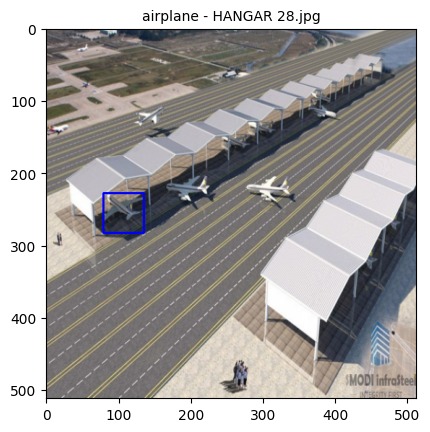

In [185]:
for i in range(1):
    idx, image, label = next(iter(train_dataloader))

    image = torch.permute(image[0], (2,1,0)).numpy()
    image = np.ascontiguousarray(image, dtype=np.uint8)
    cv2.rectangle(image, (xmin_reescaled[idx.item()], ymin_reescaled[idx.item()]), (xmax_reescaled[idx.item()], ymax_reescaled[idx.item()]), color=(0,0,255), thickness=2) #[1,3,512,512]
    
    plt.figure()
    plt.title(f'{label[0]} - {train_annotations["filename"][idx[0].item()]}', fontdict={'fontsize': 10})
    plt.imshow(image)
    plt.show()